In [319]:
# package
import numpy as np
import pandas as pd
import torch
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

In [320]:
# load data
cars_file = 'https://gist.githubusercontent.com/noamross/e5d3e859aa0c794be10b/raw/b999fb4425b54c63cab088c0ce2c0d6ce961a563/cars.csv'
cars = pd.read_csv(cars_file)
cars.head()

,Unnamed: 0,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [321]:
# convert data to tensors
X_list = cars.wt.values
X_np = np.array(X_list, dtype=np.float32).reshape(-1, 1)
y_list = cars.mpg.values
y_np = np.array(y_list, dtype=np.float32).reshape(-1, 1)
X = torch.from_numpy(X_np)
y_true = torch.from_numpy(y_np)

### Dataset

In [322]:
class LinearRegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

### DataLoader

In [323]:
train_loader = DataLoader(dataset = LinearRegressionDataset(X_np, y_np), batch_size=2)

In [324]:
# check trainloader
for i, data in enumerate(train_loader):
    print(f"{i}th batch")
    print(data)

0th batch
[tensor([[2.6200],
        [2.8750]]), tensor([[21.],
        [21.]])]
1th batch
[tensor([[2.3200],
        [3.2150]]), tensor([[22.8000],
        [21.4000]])]
2th batch
[tensor([[3.4400],
        [3.4600]]), tensor([[18.7000],
        [18.1000]])]
3th batch
[tensor([[3.5700],
        [3.1900]]), tensor([[14.3000],
        [24.4000]])]
4th batch
[tensor([[3.1500],
        [3.4400]]), tensor([[22.8000],
        [19.2000]])]
5th batch
[tensor([[3.4400],
        [4.0700]]), tensor([[17.8000],
        [16.4000]])]
6th batch
[tensor([[3.7300],
        [3.7800]]), tensor([[17.3000],
        [15.2000]])]
7th batch
[tensor([[5.2500],
        [5.4240]]), tensor([[10.4000],
        [10.4000]])]
8th batch
[tensor([[5.3450],
        [2.2000]]), tensor([[14.7000],
        [32.4000]])]
9th batch
[tensor([[1.6150],
        [1.8350]]), tensor([[30.4000],
        [33.9000]])]
10th batch
[tensor([[2.4650],
        [3.5200]]), tensor([[21.5000],
        [15.5000]])]
11th batch
[tensor([[3.4350]

In [325]:
data[0].shape # batch size, number of features

torch.Size([2, 1])

### Model

In [326]:
class LinearRegressionTorch(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegressionTorch, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        out = self.linear(x)
        return out

### Trainning

In [327]:
input_dim = 1
output_dim = 1
model = LinearRegressionTorch(input_dim, output_dim)

In [328]:
loss_fun = nn.MSELoss()

In [329]:
LR = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

In [330]:
# Training loop cải tiến
losses, slope, bias = [], [], []

NUM_EPOCHS = 1000
for epoch in range(NUM_EPOCHS+1):
    model.train()  # Đặt model ở training mode
    
    for i, (X_batch, y_batch) in enumerate(train_loader):
        # set gradient to zero
        optimizer.zero_grad()

        # forward pass
        y_pred = model(X_batch)

        # compute loss
        loss = loss_fun(y_pred, y_batch)

        # backward
        loss.backward()

        # update weights
        optimizer.step()

    # Lấy parameters sau mỗi epoch (không phải mỗi batch)
    with torch.no_grad():
        for name, param in model.named_parameters():
            if name == 'linear.weight':
                slope.append(param.detach().numpy()[0][0])
            elif name == 'linear.bias':
                bias.append(param.detach().numpy()[0])
        
        # Tính loss cho toàn bộ dataset
        model.eval()
        full_pred = model(X)
        epoch_loss = loss_fun(full_pred, y_true)
        losses.append(float(epoch_loss.detach()))

    # print loss
    if epoch % 100 == 0:
        print('Epoch: {}, Loss: {:.4f}'.format(epoch, epoch_loss.detach()))

Epoch: 0, Loss: 106.7362
Epoch: 100, Loss: 10.1708
Epoch: 200, Loss: 9.4535
Epoch: 300, Loss: 9.4543
Epoch: 400, Loss: 9.4549
Epoch: 500, Loss: 9.4549
Epoch: 600, Loss: 9.4549
Epoch: 700, Loss: 9.4549
Epoch: 800, Loss: 9.4549
Epoch: 900, Loss: 9.4549
Epoch: 1000, Loss: 9.4549


<Axes: >

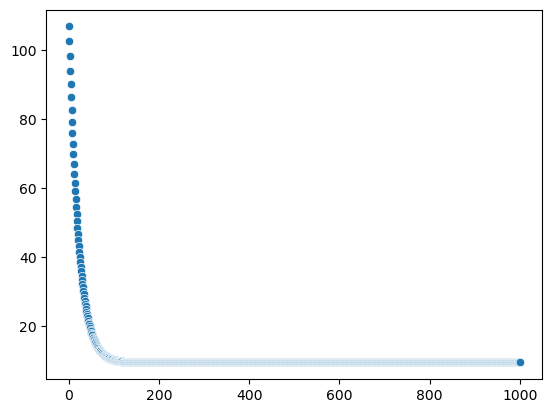

In [331]:
sns.scatterplot(x=range(len(losses)), y=losses)

<Axes: >

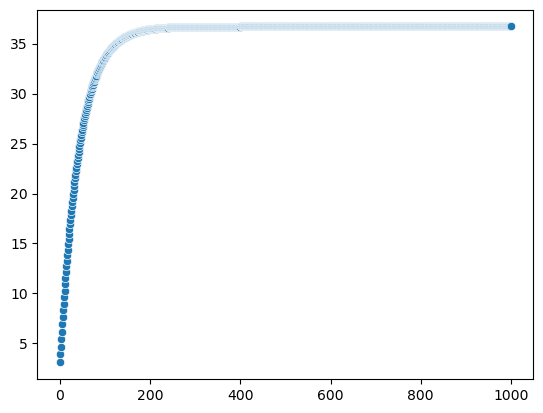

In [332]:
sns.scatterplot(x=range(len(bias)), y=bias)

<Axes: >

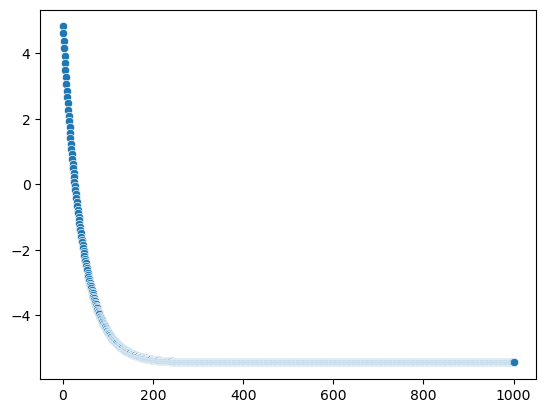

In [333]:
sns.scatterplot(x=range(len(slope)), y=slope)

<Axes: >

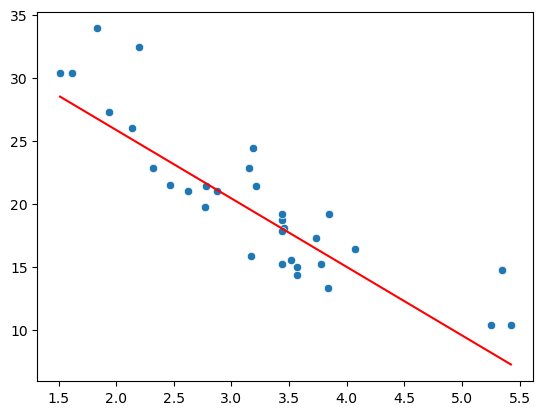

In [334]:
y_pred = model(X).data.numpy().reshape(-1)
sns.scatterplot(x=X_list, y=y_list)
sns.lineplot(x=X_list, y=y_pred, color='red')

### Model saving and loading

In [335]:
model.state_dict()

OrderedDict([('linear.weight', tensor([[-5.4371]])),
             ('linear.bias', tensor([36.7174]))])

In [336]:
torch.save(model.state_dict(), 'models/linear_model_state_dict.pth')

In [337]:
# load model
model = LinearRegressionTorch(input_dim, output_dim)
model.load_state_dict(torch.load('models/linear_model_state_dict.pth'))

/var/folders/s2/tr8rp49x6n55zdz1_59v5pj40000gn/T/ipykernel_86996/2333186099.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/line

<All keys matched successfully>

In [338]:
model.eval()

LinearRegressionTorch(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

In [339]:
model.state_dict()

OrderedDict([('linear.weight', tensor([[-5.4371]])),
             ('linear.bias', tensor([36.7174]))])

### Hyperparameter Tuning
**Network topology**:
- Number of nodes
- Layer types
- Activation funcitons

**Network objects**:
- Loss funciton
- Optimizer

**Model trainning**:
- Learning rate
- Batch size
- Number of epochs



In [340]:
!pip install skorch


[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [341]:
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV

In [342]:
learning_rate = 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [347]:
net = NeuralNetRegressor(
    LinearRegressionTorch(input_dim, output_dim),
    max_epochs=100,
    lr=learning_rate,
    iterator_train__shuffle=True
)

In [348]:
net.set_params(train_split=False, verbose=0)
params = {
    'lr': [0.02, 0.05, 0.08],
    'max_epochs': [10, 200, 500],
}

gs = GridSearchCV(net, params, scoring='r2', cv=3, verbose=2)
gs.fit(X, y_true)


print(f"Best score: {gs.best_score_}, best params: {gs.best_params_}")


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .............................lr=0.02, max_epochs=10; total time=   0.0s
[CV] END .............................lr=0.02, max_epochs=10; total time=   0.0s
[CV] END .............................lr=0.02, max_epochs=10; total time=   0.0s
[CV] END ............................lr=0.02, max_epochs=200; total time=   0.1s
[CV] END ............................lr=0.02, max_epochs=200; total time=   0.1s
[CV] END ............................lr=0.02, max_epochs=200; total time=   0.1s
[CV] END ............................lr=0.02, max_epochs=500; total time=   0.3s
[CV] END ............................lr=0.02, max_epochs=500; total time=   0.2s
[CV] END ............................lr=0.02, max_epochs=500; total time=   0.2s
[CV] END .............................lr=0.05, max_epochs=10; total time=   0.0s
[CV] END .............................lr=0.05, max_epochs=10; total time=   0.0s
[CV] END .............................lr=0.05, ma

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1196: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0, dtype=np.float64)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [-2.63692500e+00 -4.27970346e-01  3.70109128e-01 -2.33962200e+00
  3.70868064e-01  5.87620899e-01 -5.47785469e+01 -3.68337324e+19
            -inf]
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1062: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Best score: 0.5876208993942722, best params: {'lr': 0.05, 'max_epochs': 500}
